The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install git+https://github.com/d2l-ai/d2l-zh@release  # installing d2l


# 注意力评分函数
:label:`sec_attention-scoring-functions`

 :numref:`sec_nadaraya-watson`使用了高斯核来对查询和键之间的关系建模。
 :eqref:`eq_nadaraya-watson-gaussian`中的
高斯核指数部分可以视为*注意力评分函数*（attention scoring function），
简称*评分函数*（scoring function），
然后把这个函数的输出结果输入到softmax函数中进行运算。
通过上述步骤，将得到与键对应的值的概率分布（即注意力权重）。
最后，注意力汇聚的输出就是基于这些注意力权重的值的加权和。

从宏观来看，上述算法可以用来实现
 :numref:`fig_qkv`中的注意力机制框架。
 :numref:`fig_attention_output`说明了
如何将注意力汇聚的输出计算成为值的加权和，
其中$a$表示注意力评分函数。
由于注意力权重是概率分布，
因此加权和其本质上是加权平均值。

![计算注意力汇聚的输出为值的加权和](../img/attention-output.svg)
:label:`fig_attention_output`

用数学语言描述，假设有一个查询
$\mathbf{q} \in \mathbb{R}^q$和
$m$个“键－值”对
$(\mathbf{k}_1, \mathbf{v}_1), \ldots, (\mathbf{k}_m, \mathbf{v}_m)$，
其中$\mathbf{k}_i \in \mathbb{R}^k$，$\mathbf{v}_i \in \mathbb{R}^v$。
注意力汇聚函数$f$就被表示成值的加权和：

$$f(\mathbf{q}, (\mathbf{k}_1, \mathbf{v}_1), \ldots, (\mathbf{k}_m, \mathbf{v}_m)) = \sum_{i=1}^m \alpha(\mathbf{q}, \mathbf{k}_i) \mathbf{v}_i \in \mathbb{R}^v,$$
:eqlabel:`eq_attn-pooling`

其中查询$\mathbf{q}$和键$\mathbf{k}_i$的注意力权重（标量）
是通过注意力评分函数$a$将两个向量映射成标量，
再经过softmax运算得到的：

$$\alpha(\mathbf{q}, \mathbf{k}_i) = \mathrm{softmax}(a(\mathbf{q}, \mathbf{k}_i)) = \frac{\exp(a(\mathbf{q}, \mathbf{k}_i))}{\sum_{j=1}^m \exp(a(\mathbf{q}, \mathbf{k}_j))} \in \mathbb{R}.$$
:eqlabel:`eq_attn-scoring-alpha`

正如上图所示，选择不同的注意力评分函数$a$会导致不同的注意力汇聚操作。
本节将介绍两个流行的评分函数，稍后将用他们来实现更复杂的注意力机制。


In [1]:
import tensorflow as tf
from d2l import tensorflow as d2l

## [**掩蔽softmax操作**]

正如上面提到的，softmax操作用于输出一个概率分布作为注意力权重。
在某些情况下，并非所有的值都应该被纳入到注意力汇聚中。
例如，为了在 :numref:`sec_machine_translation`中高效处理小批量数据集，
某些文本序列被填充了没有意义的特殊词元。
为了仅将有意义的词元作为值来获取注意力汇聚，
可以指定一个有效序列长度（即词元的个数），
以便在计算softmax时过滤掉超出指定范围的位置。
下面的`masked_softmax`函数
实现了这样的*掩蔽softmax操作*（masked softmax operation），
其中任何超出有效长度的位置都被掩蔽并置为0。


In [2]:
#@save
def masked_softmax(X, valid_lens):
    """通过在最后一个轴上掩蔽元素来执行softmax操作"""
    # X:3D张量，valid_lens:1D或2D张量
    if valid_lens is None:
        return tf.nn.softmax(X, axis=-1)
    else:
        shape = X.shape
        if len(valid_lens.shape) == 1:
            valid_lens = tf.repeat(valid_lens, repeats=shape[1])

        else:
            valid_lens = tf.reshape(valid_lens, shape=-1)
        # 最后一轴上被掩蔽的元素使用一个非常大的负值替换，从而其softmax输出为0
        X = d2l.sequence_mask(tf.reshape(X, shape=(-1, shape[-1])),
                              valid_lens, value=-1e6)
        return tf.nn.softmax(tf.reshape(X, shape=shape), axis=-1)

为了[**演示此函数是如何工作**]的，
考虑由两个$2 \times 4$矩阵表示的样本，
这两个样本的有效长度分别为$2$和$3$。
经过掩蔽softmax操作，超出有效长度的值都被掩蔽为0。


In [3]:
masked_softmax(tf.random.uniform(shape=(2, 2, 4)), tf.constant([2, 3]))

<tf.Tensor: shape=(2, 2, 4), dtype=float32, numpy=
array([[[0.5477515 , 0.4522485 , 0.        , 0.        ],
        [0.49275386, 0.50724614, 0.        , 0.        ]],

       [[0.35934344, 0.36562124, 0.27503535, 0.        ],
        [0.31936297, 0.30021226, 0.38042477, 0.        ]]], dtype=float32)>

同样，也可以使用二维张量，为矩阵样本中的每一行指定有效长度。


In [4]:
masked_softmax(tf.random.uniform(shape=(2, 2, 4)), tf.constant([[1, 3], [2, 4]]))

<tf.Tensor: shape=(2, 2, 4), dtype=float32, numpy=
array([[[1.        , 0.        , 0.        , 0.        ],
        [0.41652182, 0.28159037, 0.30188784, 0.        ]],

       [[0.54119605, 0.45880392, 0.        , 0.        ],
        [0.16653909, 0.22749949, 0.3451354 , 0.2608261 ]]], dtype=float32)>

## [**加性注意力**]
:label:`subsec_additive-attention`

一般来说，当查询和键是不同长度的矢量时，可以使用加性注意力作为评分函数。
给定查询$\mathbf{q} \in \mathbb{R}^q$和
键$\mathbf{k} \in \mathbb{R}^k$，
*加性注意力*（additive attention）的评分函数为

$$a(\mathbf q, \mathbf k) = \mathbf w_v^\top \text{tanh}(\mathbf W_q\mathbf q + \mathbf W_k \mathbf k) \in \mathbb{R},$$
:eqlabel:`eq_additive-attn`

其中可学习的参数是$\mathbf W_q\in\mathbb R^{h\times q}$、
$\mathbf W_k\in\mathbb R^{h\times k}$和
$\mathbf w_v\in\mathbb R^{h}$。
如 :eqref:`eq_additive-attn`所示，
将查询和键连结起来后输入到一个多层感知机（MLP）中，
感知机包含一个隐藏层，其隐藏单元数是一个超参数$h$。
通过使用$\tanh$作为激活函数，并且禁用偏置项。

下面来实现加性注意力。


In [5]:
#@save
class AdditiveAttention(tf.keras.layers.Layer):
    """Additiveattention."""
    def __init__(self, key_size, query_size, num_hiddens, dropout, **kwargs):
        super().__init__(**kwargs)
        self.W_k = tf.keras.layers.Dense(num_hiddens, use_bias=False)
        self.W_q = tf.keras.layers.Dense(num_hiddens, use_bias=False)
        self.w_v = tf.keras.layers.Dense(1, use_bias=False)
        self.dropout = tf.keras.layers.Dropout(dropout)

    def call(self, queries, keys, values, valid_lens, **kwargs):
        queries, keys = self.W_q(queries), self.W_k(keys)
        # 在维度扩展后，
        # queries的形状：(batch_size，查询的个数，1，num_hidden)
        # key的形状：(batch_size，1，“键－值”对的个数，num_hiddens)
        # 使用广播方式进行求和
        features = tf.expand_dims(queries, axis=2) + tf.expand_dims(
            keys, axis=1)
        features = tf.nn.tanh(features)
        # self.w_v仅有一个输出，因此从形状中移除最后那个维度。
        # scores的形状：(batch_size，查询的个数，“键-值”对的个数)
        scores = tf.squeeze(self.w_v(features), axis=-1)
        self.attention_weights = masked_softmax(scores, valid_lens)
        # values的形状：(batch_size，“键－值”对的个数，值的维度)
        return tf.matmul(self.dropout(
            self.attention_weights, **kwargs), values)

用一个小例子来[**演示上面的`AdditiveAttention`类**]，
其中查询、键和值的形状为（批量大小，步数或词元序列长度，特征大小），
实际输出为$(2,1,20)$、$(2,10,2)$和$(2,10,4)$。
注意力汇聚输出的形状为（批量大小，查询的步数，值的维度）。


In [6]:
queries, keys = tf.random.normal(shape=(2, 1, 20)), tf.ones((2, 10, 2))
# values的小批量，两个值矩阵是相同的
values = tf.repeat(tf.reshape(
    tf.range(40, dtype=tf.float32), shape=(1, 10, 4)), repeats=2, axis=0)
valid_lens = tf.constant([2, 6])

attention = AdditiveAttention(key_size=2, query_size=20, num_hiddens=8,
                              dropout=0.1)
attention(queries, keys, values, valid_lens, training=False)

<tf.Tensor: shape=(2, 1, 4), dtype=float32, numpy=
array([[[ 2.      ,  3.      ,  4.      ,  5.      ]],

       [[10.      , 11.      , 12.000001, 13.      ]]], dtype=float32)>

尽管加性注意力包含了可学习的参数，但由于本例子中每个键都是相同的，
所以[**注意力权重**]是均匀的，由指定的有效长度决定。


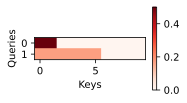

In [7]:
d2l.show_heatmaps(tf.reshape(attention.attention_weights, (1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')

## [**缩放点积注意力**]

使用点积可以得到计算效率更高的评分函数，
但是点积操作要求查询和键具有相同的长度$d$。
假设查询和键的所有元素都是独立的随机变量，
并且都满足零均值和单位方差，
那么两个向量的点积的均值为$0$，方差为$d$。
为确保无论向量长度如何，
点积的方差在不考虑向量长度的情况下仍然是$1$，
我们再将点积除以$\sqrt{d}$，
则*缩放点积注意力*（scaled dot-product attention）评分函数为：

$$a(\mathbf q, \mathbf k) = \mathbf{q}^\top \mathbf{k}  /\sqrt{d}.$$

在实践中，我们通常从小批量的角度来考虑提高效率，
例如基于$n$个查询和$m$个键－值对计算注意力，
其中查询和键的长度为$d$，值的长度为$v$。
查询$\mathbf Q\in\mathbb R^{n\times d}$、
键$\mathbf K\in\mathbb R^{m\times d}$和
值$\mathbf V\in\mathbb R^{m\times v}$的缩放点积注意力是：

$$ \mathrm{softmax}\left(\frac{\mathbf Q \mathbf K^\top }{\sqrt{d}}\right) \mathbf V \in \mathbb{R}^{n\times v}.$$
:eqlabel:`eq_softmax_QK_V`

下面的缩放点积注意力的实现使用了暂退法进行模型正则化。


In [8]:
#@save
class DotProductAttention(tf.keras.layers.Layer):
    """Scaleddotproductattention."""
    def __init__(self, dropout, **kwargs):
        super().__init__(**kwargs)
        self.dropout = tf.keras.layers.Dropout(dropout)

    # queries的形状：(batch_size，查询的个数，d)
    # keys的形状：(batch_size，“键－值”对的个数，d)
    # values的形状：(batch_size，“键－值”对的个数，值的维度)
    # valid_lens的形状:(batch_size，)或者(batch_size，查询的个数)
    def call(self, queries, keys, values, valid_lens, **kwargs):
        d = queries.shape[-1]
        scores = tf.matmul(queries, keys, transpose_b=True)/tf.math.sqrt(
            tf.cast(d, dtype=tf.float32))
        self.attention_weights = masked_softmax(scores, valid_lens)
        return tf.matmul(self.dropout(self.attention_weights, **kwargs), values)

为了[**演示上述的`DotProductAttention`类**]，
我们使用与先前加性注意力例子中相同的键、值和有效长度。
对于点积操作，我们令查询的特征维度与键的特征维度大小相同。


In [9]:
queries = tf.random.normal(shape=(2, 1, 2))
attention = DotProductAttention(dropout=0.5)
attention(queries, keys, values, valid_lens, training=False)

<tf.Tensor: shape=(2, 1, 4), dtype=float32, numpy=
array([[[ 2.      ,  3.      ,  4.      ,  5.      ]],

       [[10.      , 11.      , 12.000001, 13.      ]]], dtype=float32)>

与加性注意力演示相同，由于键包含的是相同的元素，
而这些元素无法通过任何查询进行区分，因此获得了[**均匀的注意力权重**]。


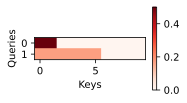

In [10]:
d2l.show_heatmaps(tf.reshape(attention.attention_weights, (1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')

## 小结

* 将注意力汇聚的输出计算可以作为值的加权平均，选择不同的注意力评分函数会带来不同的注意力汇聚操作。
* 当查询和键是不同长度的矢量时，可以使用可加性注意力评分函数。当它们的长度相同时，使用缩放的“点－积”注意力评分函数的计算效率更高。

## 练习

1. 修改小例子中的键，并且可视化注意力权重。可加性注意力和缩放的“点－积”注意力是否仍然产生相同的结果？为什么？
1. 只使用矩阵乘法，能否为具有不同矢量长度的查询和键设计新的评分函数？
1. 当查询和键具有相同的矢量长度时，矢量求和作为评分函数是否比“点－积”更好？为什么？
